In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Conv2DTranspose, Conv2D
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import numpy as np

In [ ]:
#generating autoencoder noise corresponding to every image
X_train=pickle.load(open('drive/MyDrive/Pickles/imdata_rwth_sample.pkl','rb'))
X_train = (X_train.astype(np.float32)-127.5)/127.5
encoder=load_model('drive/MyDrive/encoder.h5')
X_train_noise=encoder.predict(X_train)

In [ ]:
#defining input image dimensions
rows=120
cols=160
channels=3
img_shape = (rows,cols,channels)

In [ ]:
#building a generator
def build_generator():
  noise_shape = (100,) #1D latent vector of size 100 - Input to generator
  #building the model
  model=Sequential()
  model.add(Dense(30*40*128,input_shape=noise_shape))
  model.add(Reshape((30,40,128)))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(64,(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(3,(3,3),strides=(2,2),padding='same',activation='tanh'))

  model.summary()

  noise=Input(shape=noise_shape)
  img=model(noise) #Generated image

  return Model(noise,img)

In [ ]:
#building a discriminator
def build_discriminator():
  model=Sequential()
  model.add(Conv2D(64,kernel_size=(3,3),strides=(2,2),padding='same',input_shape=img_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Flatten())
  model.add(Dense(100))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dense(1,activation='sigmoid'))
  model.summary()

  img=Input(shape=img_shape)
  validity=model(img)

  return Model(img,validity)

In [ ]:
disc_loss=[]
gen_loss=[]

In [ ]:
def train(epochs,batch_size,save_interval):
  #loading dataset
  X_train=pickle.load(open('drive/MyDrive/Pickles/imdata_rwth_sample.pkl','rb'))
  #rescaling the images
  X_train = (X_train.astype(np.float32)-127.5)/127.5

  for epoch in range(epochs+1):
    '''
    train discriminator
    '''
    #select random batch of real images
    id=np.random.randint(0,X_train.shape[0],batch_size)
    imgs=X_train[id]

    #generate batch of fake images
    idn=np.random.randint(0,X_train_noise.shape[0],batch_size)
    gen_imgs=generator.predict(X_train_noise[idn])
    #discriminator loss
    d_loss_real=discriminator.train_on_batch(imgs,np.ones((batch_size,1)))
    d_loss_fake=discriminator.train_on_batch(gen_imgs,np.zeros((batch_size,1)))
    d_loss=0.5*np.add(d_loss_real,d_loss_fake)
    disc_loss.append(d_loss[0])
    '''
    train generator
    '''
    idn=np.random.randint(0,X_train_noise.shape[0],batch_size)
    noise=X_train_noise[idn]
    valid_y=np.array([1]*batch_size)
    #generator loss
    g_loss=combined.train_on_batch(noise,valid_y)
    gen_loss.append(g_loss)
    
    print(epoch,' ',d_loss[0],' ',g_loss)

    #saving images
    if epoch%save_interval==0:
      save_imgs(epoch)

In [ ]:
def save_imgs(epoch):
  r,c=5,5
  idn=np.random.randint(0,X_train_noise.shape[0],r*c)
  noise=X_train_noise[idn]
  gen_imgs=generator.predict(noise)
  #rescale images 0-1
  gen_imgs=0.5*gen_imgs+0.5
  
  fig,axs=plt.subplots(r,c)
  cnt=0
  for i in range(r):
    for j in range(c):
      axs[i,j].imshow(gen_imgs[cnt,:,:,:])
      axs[i,j].axis('off')
      cnt+=1
  fig.savefig("drive/MyDrive/GAN_autoencoder_images_RWTH/rwth_%d.png"%epoch)
  plt.close()
  generator.save('drive/MyDrive/GAN_autoencoder_models_RWTH/generator_model_test_autoencode_rwth_%d.h5'%epoch)

In [ ]:
#choosing the optimizer
optimizer=Adam(0.0002,0.5)

#building the discriminator
discriminator=build_discriminator()
discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

#building the generator
generator=build_generator()

#input vector
z=Input(shape=(100,))
img=generator(z)

discriminator.trainable=False

#validity from discriminator
valid=discriminator(img)

#building combined modeel
combined=Model(z,valid)
combined.compile(loss='binary_crossentropy',optimizer=optimizer)

#training the GAN
train(epochs=10000,batch_size=16,save_interval=500)

#saving the generator
generator.save('drive/MyDrive/generator_model_test_autoencode_RWTH.h5')


Streaming output truncated to the last 5000 lines.
5012   0.0021322083775885403   7.814764022827148
5013   0.03377552190795541   5.2278056144714355
5014   0.01182651793351397   5.679965496063232
5015   0.007043610792607069   6.6205291748046875
5016   0.12032247334718704   6.865230560302734
5017   0.002422508754534647   8.97404956817627
5018   0.021984518389217556   6.353944778442383
5019   0.009168845135718584   5.784339904785156
5020   0.0068406714126467705   6.514223098754883
5021   0.0035949719604104757   6.092249870300293
5022   0.004096061165910214   6.052733898162842
5023   0.003073692962061614   6.235168933868408
5024   0.0035402221838012338   6.068881988525391
5025   0.016908634454011917   5.57185697555542
5026   0.007591434405185282   6.281487464904785
5027   0.8037752509117126   40.291786193847656
5028   3.6651344391745724   19.58220672607422
5029   0.003952641136493185   14.94670581817627
5030   0.0005989737692289054   11.18933391571045
5031   0.003809046611422673   10.27081

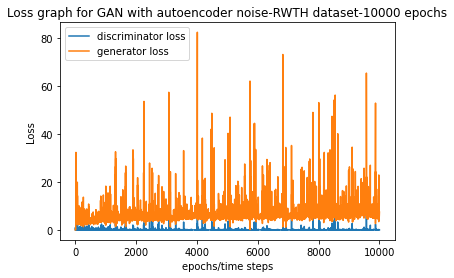

In [ ]:
import matplotlib.pyplot as plt
plt.plot(disc_loss,label='discriminator loss')
plt.plot(gen_loss,label='generator loss')
plt.xlabel('epochs/time steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss graph for GAN with autoencoder noise-RWTH dataset-10000 epochs')
plt.show()

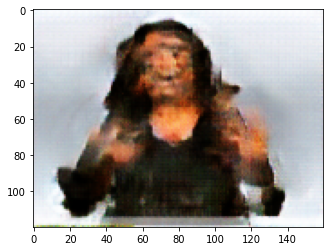

In [ ]:
#Generating random image
from numpy.random import randn
gm=load_model('drive/MyDrive/generator_model_test_autoencode_RWTH.h5')
id=np.random.randint(0,X_train_noise.shape[0],1)
vector=X_train_noise[id]
image=gm.predict(vector)
image=image*0.5+0.5
plt.imshow(image[0,:,:,:])